# Bike Rental Usage Prediction - Regression Problem


![Bike Rental](resources/Nice_Ride_Bike_Kiosk.jpg)

---

#### Data Fields Explanation

- Data Reference: 
    - This Hadi Fanaee-T
    - Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto INESC Porto, Campus da FEUP Rua Dr. Roberto Frias, 378 4200 - 465 Porto, Portugal

- Data Description: 
    - instant: record index
    - dteday : date
    - season : season (1:springer, 2:summer, 3:fall, 4:winter)
    - yr : year (0: 2011, 1:2012)
    - mnth : month ( 1 to 12)
    - hr : hour (0 to 23)
    - holiday : wether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
    - weekday : day of the week
    - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
    + weathersit : 
        - 1: Clear, Few clouds, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
    - hum: Normalized humidity. The values are divided to 100 (max)
    - windspeed: Normalized wind speed. The values are divided to 67 (max)
    - casual: count of casual users
    - registered: count of registered users
    - cnt: count of total rental bikes including both casual and registered
---

## Library Imports

In [26]:
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print(f"Using Tensorflow Version - {tf.__version__}")

Using Tensorflow Version - 2.9.1


In [27]:
# Verify GPU availability and Usage

# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load the Dataset

In [28]:
bike = pd.read_csv('resources/bike_sharing_daily.csv')

# Check the initial rows
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,82,1518,1600


In [29]:
# Check the data structure
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(3), int64(11), object(1)
memory usage: 85.8+ KB


In [30]:
# Check for any missing values
sum(bike.isna().sum())

0

In [31]:
# Check the descriptive stats
bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.972500,0.507463,3410.000000,6946.000000,8714.000000


## Some Data Preprocessing

In [32]:
# We will drop the attributes, we dont need for modelling
bike = bike.drop(labels=['instant', 'casual', 'registered'], axis=1)

# Check few rows to verify the drop
bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1/1/2011,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
1,1/2/2011,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2,1/3/2011,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
3,1/4/2011,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
4,1/5/2011,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


In [33]:

# make the dteday column as the index column
bike.index = pd.DatetimeIndex(bike['dteday'])

# Once it is done, drop the column as it is not needed in modelling
bike.drop(labels=['dteday'], axis=1, inplace=True)

# Check the initial rows for verification
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


## Data Visualizations

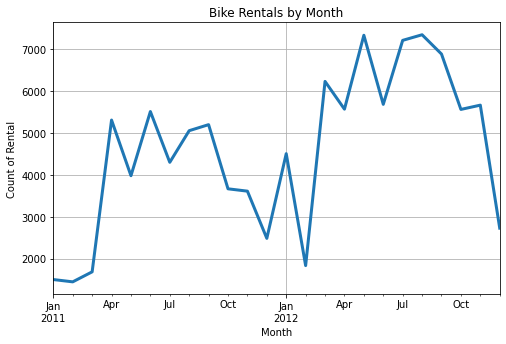

In [34]:
# we will visualize the target variable with respect to the date(index)
plt.figure(figsize=(8, 5))
bike['cnt'].asfreq('M').plot(linewidth=3)
plt.title("Bike Rentals by Month")
plt.xlabel("Month")
plt.ylabel("Count of Rental")
plt.grid(True)

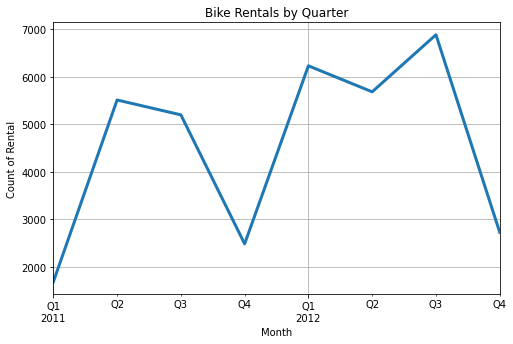

In [35]:
# we will visualize the target variable with respect to the date(index)
plt.figure(figsize=(8, 5))
bike['cnt'].asfreq('Q').plot(linewidth=3)
plt.title("Bike Rentals by Quarter")
plt.xlabel("Month")
plt.ylabel("Count of Rental")
plt.grid(True)

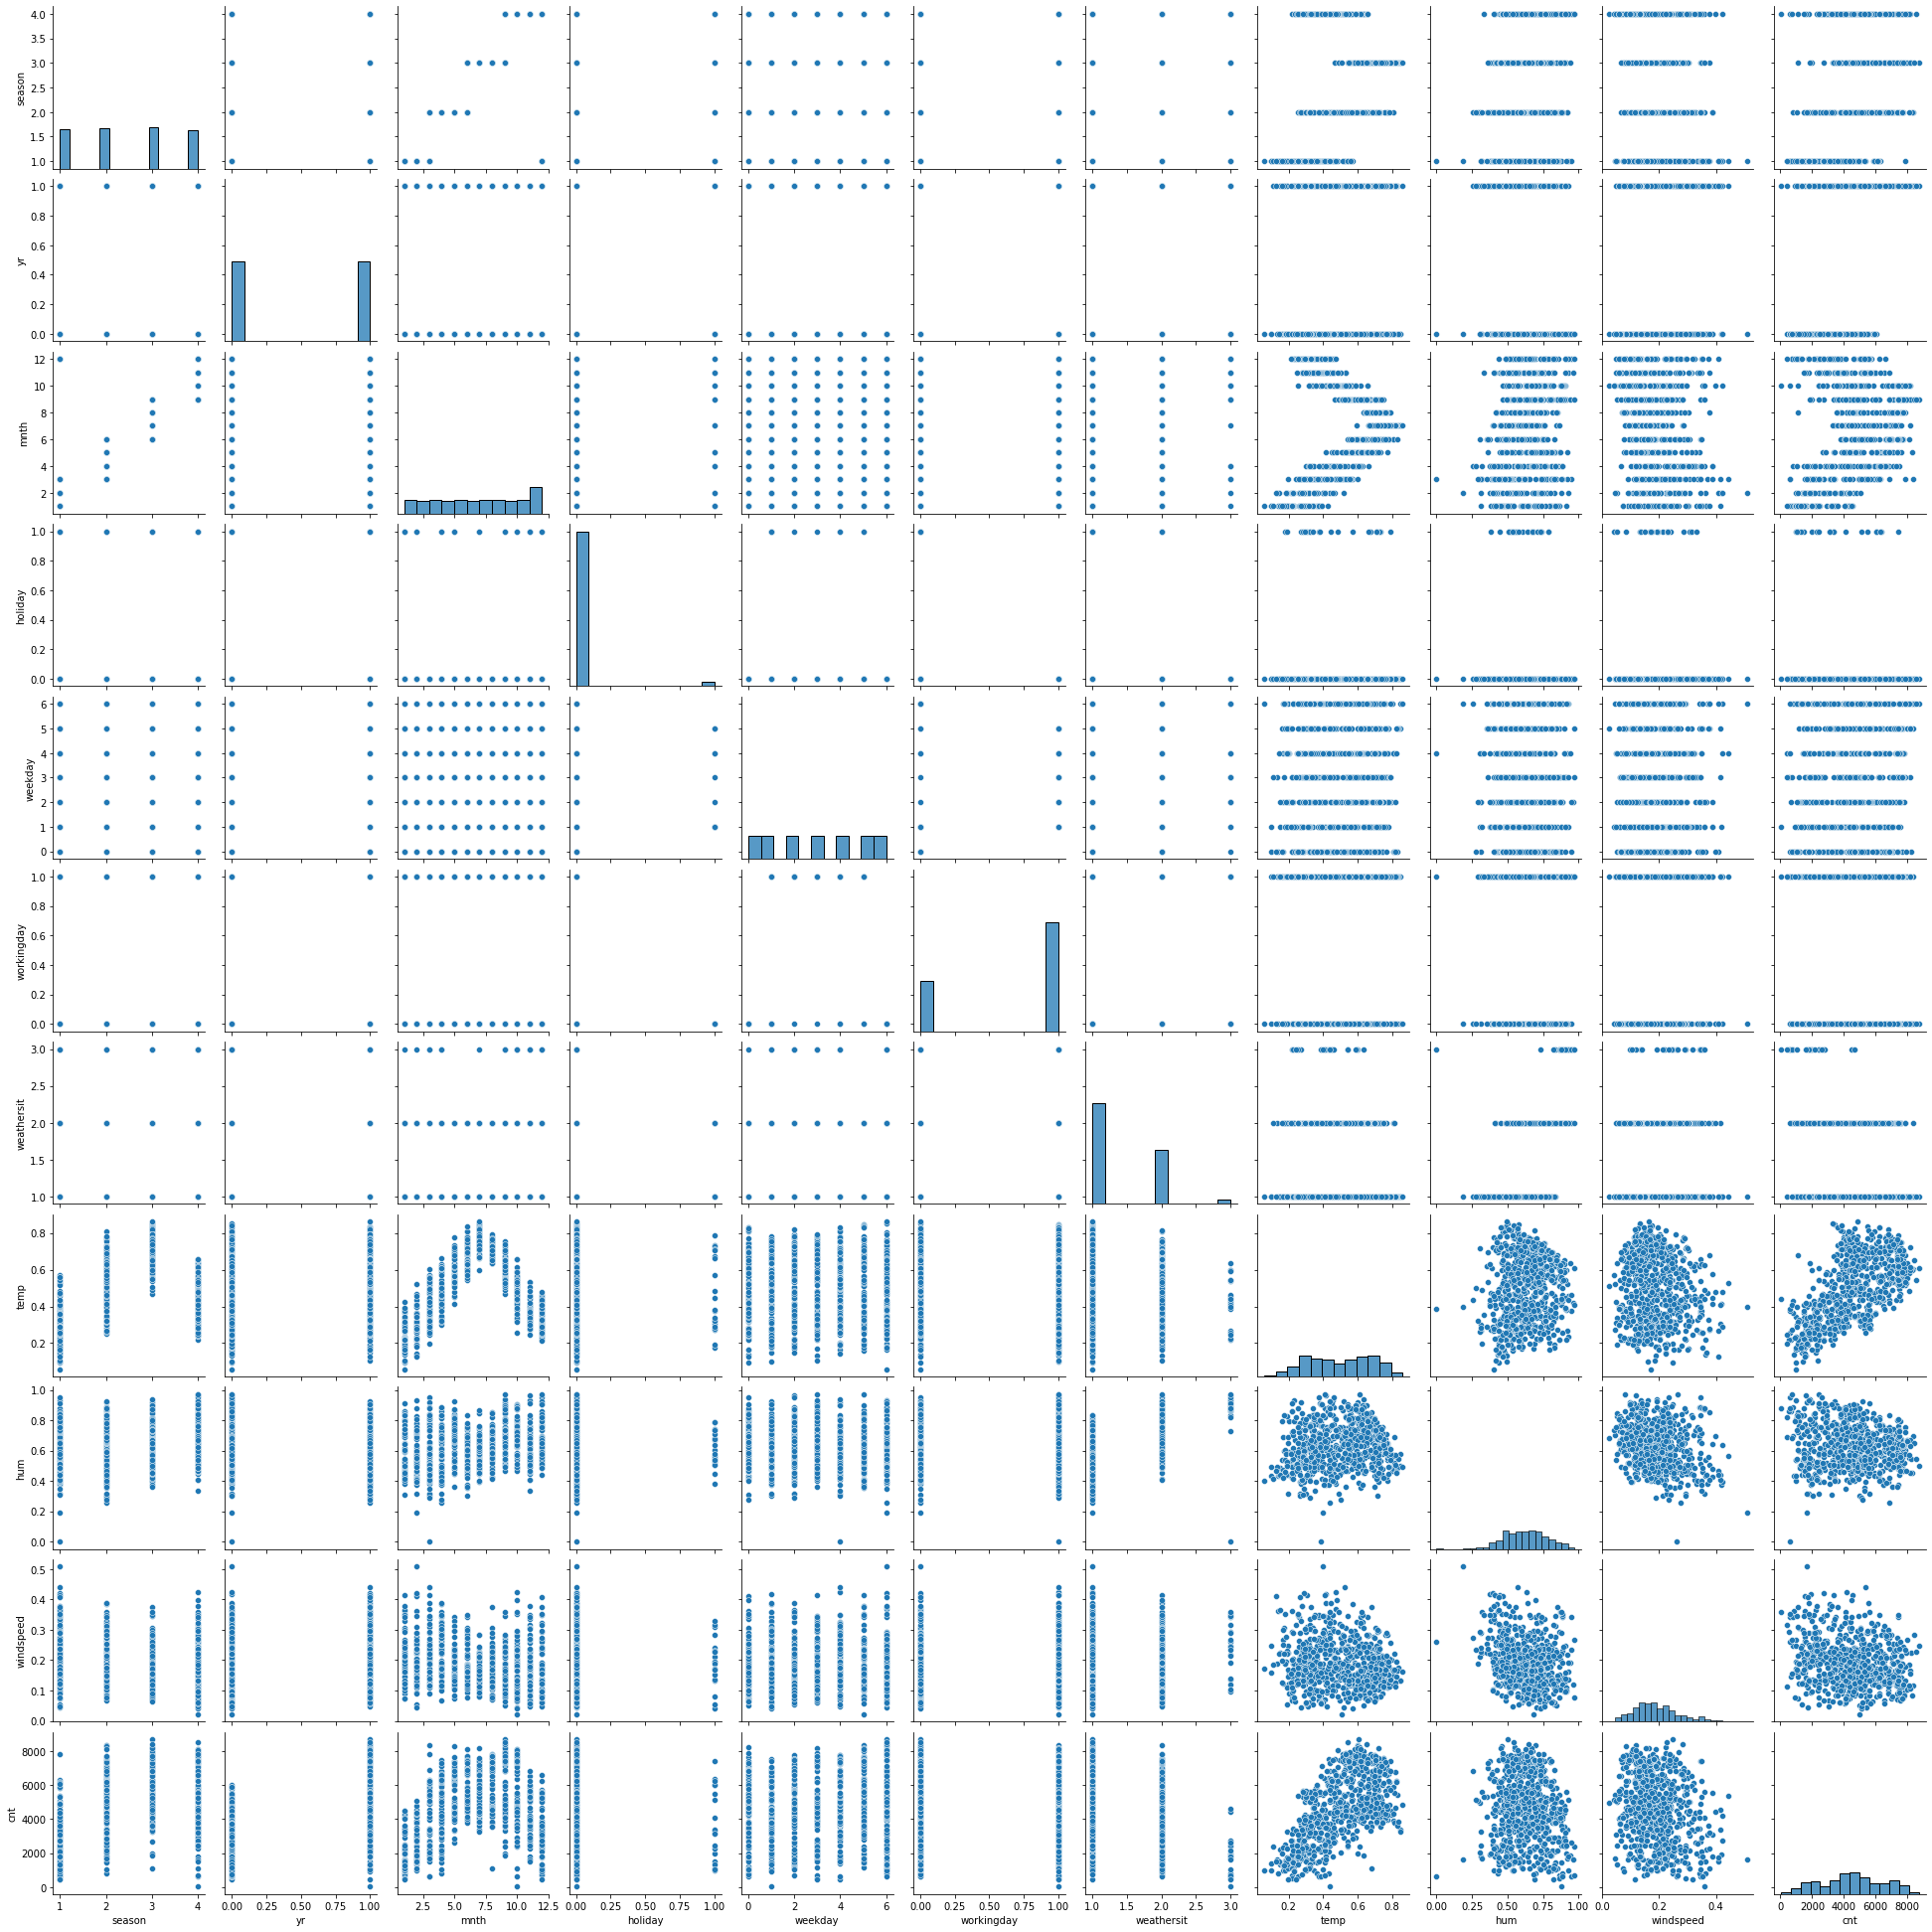

In [36]:
# Lets do a pairplot across the dataset
sns.pairplot(bike)

<AxesSubplot:>

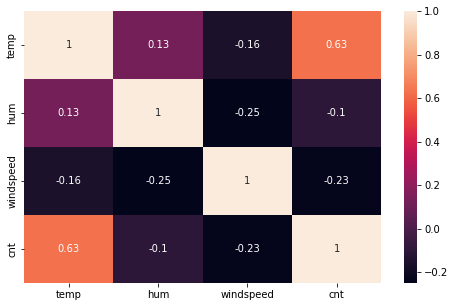

In [37]:
# Lets view the correlation heatmap between the numerical features
X_numerical = bike[['temp', 'hum', 'windspeed', 'cnt']]
X_categorical = bike[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']]

plt.figure(figsize=(8, 5))
sns.heatmap(X_numerical.corr(), annot=True)

## Data Preparation

In [38]:
# We will do onehot encoding of the categorical features
oneHotEncoder = OneHotEncoder()
X_categorical = oneHotEncoder.fit_transform(X_categorical).toarray()

# One hot encoder creates a sparse matrix, which needs to be converted to dataframe , hence it was converted to array first before
X_categorical = pd.DataFrame(X_categorical)


# Check the shape of the categorical feature array
print(f"Shape of the Categorical OneHotEncoded Feature - {X_categorical.shape}")

Shape of the Categorical OneHotEncoded Feature - (731, 32)


In [39]:
# Now we will reset the index of the numerical features
X_numerical = X_numerical.reset_index()
X_numerical.head()

,dteday,temp,hum,windspeed,cnt
0,2011-01-01,0.344167,0.805833,0.160446,985
1,2011-01-02,0.363478,0.696087,0.248539,801
2,2011-01-03,0.196364,0.437273,0.248309,1349
3,2011-01-04,0.200000,0.590435,0.160296,1562
4,2011-01-05,0.226957,0.436957,0.186900,1600


In [40]:
# Now we will join both the dataframes after one hot encoded feature
X_all = pd.concat([X_numerical, X_categorical], axis=1)

# Then we will remove the dteday attribue
X_all = X_all.drop(labels=['dteday'], axis=1)

X_all.head()

,temp,hum,windspeed,cnt,0,1,2,3,4,5,...,22,23,24,25,26,27,28,29,30,31
0,0.344167,0.805833,0.160446,985,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.363478,0.696087,0.248539,801,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.196364,0.437273,0.248309,1349,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.200000,0.590435,0.160296,1562,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.226957,0.436957,0.186900,1600,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [41]:
# Seggregate the feature and target attributes as numpy arrays
X = X_all.drop(labels=['cnt'], axis = 1).values

y = X_all['cnt'].values
y = y.reshape(-1, 1)

print(f"Shape of features - {X.shape}")
print(f"Shape of target - {y.shape}")

Shape of features - (731, 35)
Shape of target - (731, 1)


In [42]:
# we would need to scale the target variable.. we will use min max scaler
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [43]:
# We will split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Build and Train the Model

In [44]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=80, activation=tf.keras.activations.relu, input_shape=(X.shape[1],)))
model.add(tf.keras.layers.Dense(units=80, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=80, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1, activation=tf.keras.activations.linear))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')

# Check the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 80)                2880      
                                                                 
 dense_5 (Dense)             (None, 80)                6480      
                                                                 
 dense_6 (Dense)             (None, 80)                6480      
                                                                 
 dense_7 (Dense)             (None, 1)                 81        
                                                                 
Total params: 15,921
Trainable params: 15,921
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Train the model
epochs_hist = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_split=0.2)

Epoch 1/100
10/10 [==============================] - 1s 34ms/step - loss: 0.1442 - val_loss: 0.0836
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0463 - val_loss: 0.0242
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0202 - val_loss: 0.0132
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0147 - val_loss: 0.0118
Epoch 5/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0121 - val_loss: 0.0098
Epoch 6/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 7/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 8/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 9/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 10/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0072 - val_loss: 0.0075

## Evaluate the Model

In [46]:
# Check the training object keys
epochs_hist.history.keys()

dict_keys(['loss', 'val_loss'])

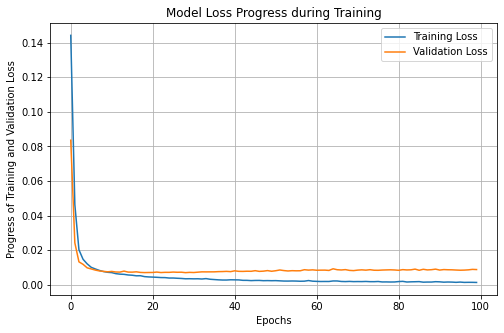

In [47]:
# Lets plot the loss and validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress during Training')
plt.xlabel('Epochs')
plt.ylabel('Progress of Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid(True)

5/5 [==============================] - 0s 2ms/step


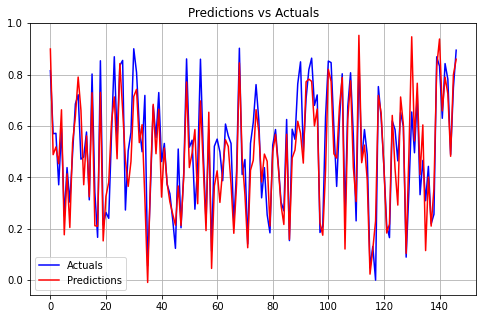

In [48]:
# Lets run the predictions
predictions = model.predict(X_test)

plt.figure(figsize=(8, 5))
plt.plot(y_test, color='b')
plt.plot(predictions, color='r')
plt.title('Predictions vs Actuals')
plt.legend(['Actuals', 'Predictions'])
plt.grid(True)

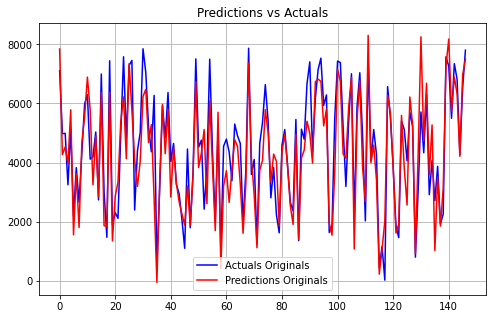

In [49]:
# Now do an inverse scalar transform and plot on the original value
predictions_orig = scaler.inverse_transform(predictions)
y_test_orig = scaler.inverse_transform(y_test)

plt.figure(figsize=(8, 5))
plt.plot(y_test_orig, color='b')
plt.plot(predictions_orig, color='r')
plt.title('Predictions vs Actuals')
plt.legend(['Actuals Originals', 'Predictions Originals'])
plt.grid(True)

## Regression Metrics

In [50]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, predictions_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, predictions_orig)
MAE = mean_absolute_error(y_test_orig, predictions_orig)
r2 = r2_score(y_test_orig, predictions_orig)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 908.839 
MSE = 825988.1519544038 
MAE = 700.133588829819 
R2 = 0.7836893136779046 
Adjusted R2 = 0.7154832414141808
